# HomeWork 02

 We will extract interesting information from www.topuniversities.com and www.timeshighereducation.com in order to analyse universities ranking from different perspectives.

In [1]:
# Import libraries
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import widgets,interact
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper functions

'''
Aggregating the data by  country and region.

The following function helped us to rank the universities according to the column of wish and according to Countries 
or Regions. Furthermore we also define two functions, CountryStdMean and RegionStdMean which each one creates a 
DataFrame with the mean and std values of the universities of eachy country or region.
'''

## Ranking of the universities according to a country
def country_ranking(column_ranking,data_frame, order=False):
    countrySortResults = data_frame
    
    #Sorting and Indexing the DataFrame
    countrySortResults = countrySortResults.sort_values(['region','country'],ascending=[False,False])
    countrySortResults = countrySortResults.set_index(['region','country'])

    # Here we check if there are some regions  country with only one university in the top as they are already sorted 
    allRegionList = np.unique(data_frame['region'],return_counts=True)[0]
    #allRegionCount = np.unique(data_frame['region'],return_counts=True)[1]
    #allNonUniqueRegionList = np.delete(allRegionList ,np.where(allRegionCount == 1), axis=0)
           
    for j in allRegionList:
        
        countryDF = countrySortResults.loc[j]
        
        #We only concider countries that have multiple universities as it would be usless to sort countries 
        #with only one university
        
        allCountriesList = np.unique(countryDF.index,return_counts=True)[0]
        allCountriesCount = np.unique(countryDF.index,return_counts=True)[1]
        allNonUniqueCountryList = np.delete(allCountriesList ,np.where(allCountriesCount == 1), axis=0)     
        
        for i in allNonUniqueCountryList:
            countrySortResults.loc[j,i] = countrySortResults.loc[j,i].sort_values(column_ranking,ascending=order)
        
    #put the ratio in front
    cols=list(countrySortResults)
    cols.insert(1, cols.pop(cols.index(column_ranking)))
    countrySortResults = countrySortResults.loc[:, cols]
    return countrySortResults

# Function that calculates the mean and std of the column of which by country.
def CountryStdMean(column_ranking,data_frame):
    
    countrySortResults = data_frame    
    countrySortResults = countrySortResults.set_index(['region','country'])
    allRegionList = np.unique(data_frame['region'],return_counts=True)[0]
    
    AllCountries = (np.unique(data_frame['country'],return_counts=True)[0])
    
    #Creating a DataFrame containing the mean and the std for each country   
    CountryMeanStd = pd.DataFrame(index=AllCountries)
    CountryMeanStd['Mean']= ""
    CountryMeanStd['Std'] = ""
    
    for j in allRegionList:
        
        countryDF = countrySortResults.loc[j]        
        allCountriesList = np.unique(countryDF.index,return_counts=True)[0]        
        for k in allCountriesList:
            countryData = countrySortResults.loc[j,k]
            CountryMeanStd.xs(k)['Mean'] = countryData[column_ranking].mean()
            CountryMeanStd.xs(k)['Std'] = countryData[column_ranking].std()
    
    return CountryMeanStd
    
    

# REGION RANKING
def region_ranking(column_ranking, data_frame, order=False):
    
    countrySortResults = data_frame
    # Grouping the dataFrame to have the countries and regions together in the good order
    countrySortResults = countrySortResults.sort_values('region',ascending=False)
    countrySortResults = countrySortResults.sort_values('country',ascending=False)
    countrySortResults = countrySortResults.set_index('region')
    
    # Creationg an array with all the regions presentend in the top 200
    allRegionList = np.unique(data_frame['region'],return_counts=True)[0]
    allRegionCount = np.unique(data_frame['region'],return_counts=True)[1]
    allNonUniqueRegionList = np.delete(allRegionList ,np.where(allRegionCount == 1), axis=0)

    # We take each region one by one, and sort the values inside the region according of the column of which
    for j in allNonUniqueRegionList:
        
        countryDF = countrySortResults.loc[j]
        countrySortResults.loc[j] = countrySortResults.loc[j].sort_values(column_ranking,ascending=order)

    countrySortResults = countrySortResults.set_index('country',append=True)

    cols=list(countrySortResults)
    cols.insert(1, cols.pop(cols.index(column_ranking)))
    countrySortResults = countrySortResults.loc[:, cols]
    return countrySortResults


# Function that calculates the mean and std of the column of which by region.
def regionStdMean(column_ranking, data_frame):
    
    countrySortResults = data_frame
    #DataFrame Processing    
    allRegionList = np.unique(data_frame['region'],return_counts=True)[0]
    
    #Creating a DataFrame containing the mean and the std for each country
    RegionMeanStd = pd.DataFrame(index=(np.unique(countrySortResults['region'],return_counts=True)[0]))
    RegionMeanStd['Mean']= ""
    RegionMeanStd['Std'] = ""
    
    
    countrySortResults = countrySortResults.set_index('region')
    
    # Calculating the mean and std for each region
    for j in allRegionList:
        
        countryDF = countrySortResults.loc[j]
        
        RegionData = countrySortResults.loc[j]
        RegionMeanStd.xs(j)['Mean'] = RegionData[column_ranking].mean()
        RegionMeanStd.xs(j)['Std'] = RegionData[column_ranking].std()
        
    
    return RegionMeanStd

# 200 top-ranking universties in www.topuniversities.com

First we needed to recover the data from the site. Using Postman we saw that the data were loaded from an external Json file. We used directly this file to load the data of the main page (ranking) then used the link of each page to access to further information 

In [3]:
#url of the json file found with Interceptor
URL='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
r = requests.get(URL)
page_body = r.text
dic_data = json.loads(page_body)

In [4]:
#function to get the necessary information on specific sites of each university and create our DataFrame
def number_student_faculty(soup):
    student= soup.find('div', class_='total student')
    if student==None:
        return (float('nan'),float('nan'),float('nan'),float('nan'))
    student_number=student.find('div',class_='number').text
    student_inter= soup.find('div', class_='total inter')
    student_inter_number=student_inter.find('div',class_='number').text
    members=soup.find('div',class_='total faculty')
    if members==None:
        return (float('nan'),float('nan'),float('nan'),float('nan'))
    members_number=members.find('div',class_='number').text
    members_inter=soup.find('div',class_='inter faculty')
    if members_inter==None:
        return (float('nan'),float('nan'),float('nan'),float('nan'))
    members_inter_number=members_inter.find('div',class_='number').text
    
    return (student_number[1:-1],student_inter_number[1:-1],members_number[1:-1],members_inter_number[1:-1])

As the relevant information is in detailed pages of each university we have to go into the URL of each university in the https://www.topuniversities.com/. With this we will get:
- Name, rank, country and region, 
- Number of faculty members (international and total) 
- Number of students (international and total)



In [5]:
relevant_info=['title','country','rank_display','region']
All_country=[]
for i in range(200):
    country_info={}
    URL='https://www.topuniversities.com/'+dic_data['data'][i]['url']
    r = requests.get(URL)
    page_body = r.text
    soup=BeautifulSoup(page_body, 'html.parser')
    for info in relevant_info: 
        country_info[info]=dic_data['data'][i][info]
        
    (country_info['number of students'],country_info['number of international students'],\
     country_info['number of members'],country_info['number of international members'])=number_student_faculty(soup)
    All_country.append(country_info)

#Cleaning the outputs    
All_country_1=pd.DataFrame(data=All_country)
All_country_1=All_country_1.apply(lambda x: x.str.replace(',',''))
All_country_1=All_country_1.apply(lambda x: x.str.replace('=',''))
cols = list(All_country_1)

#put the name in front
cols.insert(0, cols.pop(cols.index('title')))
All_country_1 = All_country_1.loc[:, cols]
All_country_1=All_country_1.apply(pd.to_numeric, errors='ignore')
#adding the ratio recquired
All_country_1['ratio inter student/ all student']=\
            All_country_1['number of international students']/\
            All_country_1['number of students']*100
All_country_1['ratio student/ staff']=All_country_1['number of students']/\
            All_country_1['number of members']
display(All_country_1.head())

,title,country,number of international members,number of international students,number of members,number of students,rank_display,region,ratio inter student/ all student,ratio student/ staff
0,Massachusetts Institute of Technology (MIT),United States,1679.0,3717.0,2982.0,11067.0,1,North America,33.586338,3.711268
1,Stanford University,United States,2042.0,3611.0,4285.0,15878.0,2,North America,22.742159,3.705484
2,Harvard University,United States,1311.0,5266.0,4350.0,22429.0,3,North America,23.478532,5.156092
3,California Institute of Technology (Caltech),United States,350.0,647.0,953.0,2255.0,4,North America,28.691796,2.366212
4,University of Cambridge,United Kingdom,2278.0,6699.0,5490.0,18770.0,5,Europe,35.689931,3.418944


#### We can now answer to the questions:

    - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    - Answer the previous question aggregating the data by (c) country and (d) region.
    
    We decide to rank in a ascending way the ration between student/staff as we think that having a small ratio would mean that there are more professional to take care of the students. We do not only speak about teachers but more PhD assistents, more labs to do projects, etc.
    
    We decide that a univesity with a big ratio of international students is better. Indeed a univesity with a high ratio somehow reflex it's worldwide notority. However some factors can explain why a univesity has a very low ratio, like the costs of studing in the univesity, the location, etc. 

### TOP 20 Univesities according to the ratio Student/Staff

In [6]:
classement_ratio1=All_country_1.sort_values('ratio student/ staff',ascending=True)
display(classement_ratio1.head(20))


,title,country,number of international members,number of international students,number of members,number of students,rank_display,region,ratio inter student/ all student,ratio student/ staff
3,California Institute of Technology (Caltech),United States,350.0,647.0,953.0,2255.0,4,North America,28.691796,2.366212
15,Yale University,United States,1708.0,2469.0,4940.0,12402.0,16,North America,19.908079,2.510526
5,University of Oxford,United Kingdom,2964.0,7353.0,6750.0,19720.0,6,Europe,37.287018,2.921481
4,University of Cambridge,United Kingdom,2278.0,6699.0,5490.0,18770.0,5,Europe,35.689931,3.418944
16,Johns Hopkins University,United States,1061.0,4105.0,4462.0,16146.0,17,North America,25.424254,3.618557
1,Stanford University,United States,2042.0,3611.0,4285.0,15878.0,2,North America,22.742159,3.705484
0,Massachusetts Institute of Technology (MIT),United States,1679.0,3717.0,2982.0,11067.0,1,North America,33.586338,3.711268
185,University of Rochester,United States,488.0,2805.0,2569.0,9636.0,186,North America,29.109589,3.750876
18,University of Pennsylvania,United States,1383.0,4250.0,5499.0,20639.0,19,North America,20.592083,3.753228
17,Columbia University,United States,913.0,8105.0,6189.0,25045.0,18,North America,32.361749,4.046696


### TOP 20 Univesities according to the ratio International Student/ All Students

In [7]:
classement_ratio2=All_country_1.sort_values('ratio inter student/ all student',ascending=False)
display(classement_ratio2.head(20))

,title,country,number of international members,number of international students,number of members,number of students,rank_display,region,ratio inter student/ all student,ratio student/ staff
34,London School of Economics and Political Scien...,United Kingdom,687.0,6748.0,1088.0,9760.0,35,Europe,69.139344,8.970588
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,1300.0,5896.0,1695.0,10343.0,12,Europe,57.004738,6.102065
7,Imperial College London,United Kingdom,2071.0,8746.0,3930.0,16090.0,8,Europe,54.356743,4.094148
198,Maastricht University,Netherlands,502.0,8234.0,1277.0,16385.0,200,Europe,50.253280,12.830854
47,Carnegie Mellon University,United States,425.0,6385.0,1342.0,13356.0,47,North America,47.806229,9.952310
6,UCL (University College London),United Kingdom,2554.0,14854.0,6345.0,31080.0,7,Europe,47.792793,4.898345
91,University of St Andrews,United Kingdom,485.0,4030.0,1140.0,8800.0,92,Europe,45.795455,7.719298
41,The University of Melbourne,Australia,1477.0,18030.0,3311.0,42182.0,41,Oceania,42.743350,12.739958
126,Queen Mary University of London,United Kingdom,801.0,6806.0,1885.0,16135.0,127,Europe,42.181593,8.559682
25,The University of Hong Kong,Hong Kong,2085.0,8230.0,3012.0,20214.0,26,Asia,40.714356,6.711155


### Ratio Student/Staff per country. Here we show 20 Asian univesities. 

In [9]:
Country_ranking1 = country_ranking('ratio student/ staff',All_country_1,True)
display(Country_ranking1.loc['Asia'].head(20))


,title,ratio student/ staff,number of international members,number of international students,number of members,number of students,rank_display,ratio inter student/ all student
country,,,,,,,,
Taiwan,National Taiwan University (NTU),11.469540,220.0,3152.0,2807.0,32195.0,76,9.790340
Taiwan,National Tsing Hua University,13.617647,119.0,1187.0,1020.0,13890.0,161,8.545716
South Korea,Pohang University of Science And Technology (P...,4.694277,113.0,126.0,664.0,3117.0,71,4.042348
South Korea,Sungkyunkwan University (SKKU),6.726940,324.0,2818.0,3556.0,23921.0,108,11.780444
South Korea,Korea University,6.913752,339.0,3638.0,3745.0,25892.0,90,14.050672
South Korea,Seoul National University,7.140967,433.0,2331.0,3930.0,28064.0,36,8.306015
South Korea,Yonsei University,7.153549,290.0,3379.0,3621.0,25903.0,106,13.044821
South Korea,Hanyang University,7.568233,364.0,3397.0,3085.0,23348.0,155,14.549426
South Korea,KAIST - Korea Advanced Institute of Science & ...,7.860800,147.0,584.0,1250.0,9826.0,41,5.943415


### Ratio international student/total students Per Country. Here we show 30 European univesities. 

In [10]:
Country_ranking2 = country_ranking('ratio inter student/ all student',All_country_1,False)
display(Country_ranking1.loc['Europe'].head(30))

,title,ratio student/ staff,number of international members,number of international students,number of members,number of students,rank_display,ratio inter student/ all student
country,,,,,,,,
United Kingdom,University of Oxford,2.921481,2964.0,7353.0,6750.0,19720.0,6,37.287018
United Kingdom,University of Cambridge,3.418944,2278.0,6699.0,5490.0,18770.0,5,35.689931
United Kingdom,Imperial College London,4.094148,2071.0,8746.0,3930.0,16090.0,8,54.356743
United Kingdom,UCL (University College London),4.898345,2554.0,14854.0,6345.0,31080.0,7,47.792793
United Kingdom,King's College London,6.515068,1513.0,9451.0,3650.0,23780.0,23,39.743482
United Kingdom,The University of Edinburgh,6.880982,1553.0,10551.0,4075.0,28040.0,23,37.628388
United Kingdom,University of Bristol,7.188153,942.0,5099.0,2870.0,20630.0,44,24.716432
United Kingdom,The University of Manchester,7.468432,1653.0,13514.0,4910.0,36670.0,34,36.853013
United Kingdom,University of St Andrews,7.719298,485.0,4030.0,1140.0,8800.0,92,45.795455


### Ratio Student/Staff per region . Here we show 20 North America univesities. 

In [11]:
Region_ranking1=region_ranking('ratio student/ staff',All_country_1,True) #choose from cols=list(countrySortResults)
display(Region_ranking1.loc['North America'].head(20))


,title,ratio student/ staff,number of international members,number of international students,number of members,number of students,rank_display,ratio inter student/ all student
country,,,,,,,,
United States,California Institute of Technology (Caltech),2.366212,350.0,647.0,953.0,2255.0,4,28.691796
United States,Yale University,2.510526,1708.0,2469.0,4940.0,12402.0,16,19.908079
United States,Johns Hopkins University,3.618557,1061.0,4105.0,4462.0,16146.0,17,25.424254
United States,Stanford University,3.705484,2042.0,3611.0,4285.0,15878.0,2,22.742159
United States,Massachusetts Institute of Technology (MIT),3.711268,1679.0,3717.0,2982.0,11067.0,1,33.586338
United States,University of Rochester,3.750876,488.0,2805.0,2569.0,9636.0,186,29.109589
United States,University of Pennsylvania,3.753228,1383.0,4250.0,5499.0,20639.0,19,20.592083
United States,Columbia University,4.046696,913.0,8105.0,6189.0,25045.0,18,32.361749
United States,Northwestern University,4.413850,1141.0,3422.0,4231.0,18675.0,28,18.323963


## Ratio International Students/All Students per region . Here we show 20 European univesities. 

In [12]:
Region_ranking2=region_ranking('ratio inter student/ all student',All_country_1,False)
display(Region_ranking2.loc['Europe'].head(20))

,title,ratio inter student/ all student,number of international members,number of international students,number of members,number of students,rank_display,ratio student/ staff
country,,,,,,,,
United Kingdom,London School of Economics and Political Scien...,69.139344,687.0,6748.0,1088.0,9760.0,35,8.970588
Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),57.004738,1300.0,5896.0,1695.0,10343.0,12,6.102065
United Kingdom,Imperial College London,54.356743,2071.0,8746.0,3930.0,16090.0,8,4.094148
Netherlands,Maastricht University,50.253280,502.0,8234.0,1277.0,16385.0,200,12.830854
United Kingdom,UCL (University College London),47.792793,2554.0,14854.0,6345.0,31080.0,7,4.898345
United Kingdom,University of St Andrews,45.795455,485.0,4030.0,1140.0,8800.0,92,7.719298
United Kingdom,Queen Mary University of London,42.181593,801.0,6806.0,1885.0,16135.0,127,8.559682
United Kingdom,King's College London,39.743482,1513.0,9451.0,3650.0,23780.0,23,6.515068
Netherlands,University of Groningen,39.130277,1137.0,10780.0,3351.0,27549.0,113,8.221128


## Ploting the data 

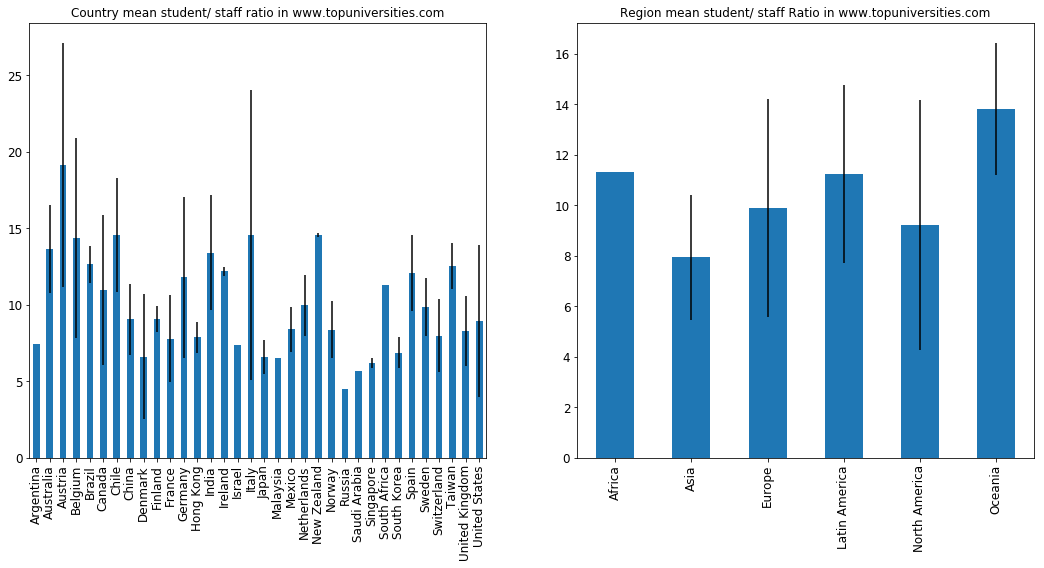

In [8]:
countrySTDMEAN = CountryStdMean('ratio student/ staff',All_country_1)
plt.subplot(1, 2, 1)
countrySTDMEAN['Mean'].plot.bar(yerr=countrySTDMEAN['Std'], figsize=(8,8), fontsize = 12,title='Country mean student/ staff ratio in www.topuniversities.com')

RegionSTDMEAN = regionStdMean('ratio student/ staff', All_country_1)
plt.subplot(1, 2, 2)
RegionSTDMEAN['Mean'].plot.bar(yerr=RegionSTDMEAN['Std'],figsize=(18,8), fontsize = 12, title='Region mean student/ staff Ratio in www.topuniversities.com')
plt.show()

## Histogram Ratio Student/ Staff Analysis

The country ratio histogram shows us the mean of the student/staff ratio per country with the std. Notice that if there is no std, it's because the countries concerned just have one university in the top 200.
In a general way we can see that the mean value of the top countries, i.e. countries with universities in the top 20 (United States, Canada, United Kingdom, Switzerland), have a lower mean compared to the general tendency. For this analysis, we don't consider countries without std as they may not be representative of their own country.
Austria has the highest mean ratio and a large std, this could suggest that the Austrians consider more the university as a place to study rather than a place to work.

The Region ratio histogram shows us that the regions that contains the most universities in the top 200 have a lower mean. This point highlights the importance of the ratio student/staff for the establishment of the ranking. The high std of Europe can be explained by the amount of countries that belong to the region. Indeed, each country has it's own politics regarding university' decision. The same reasoning can be made for the North America as each state has their own laws and education system.  
In a general way the Regions have a similar mean, as the minimal values of the ratio is of 8 and the max is 13.


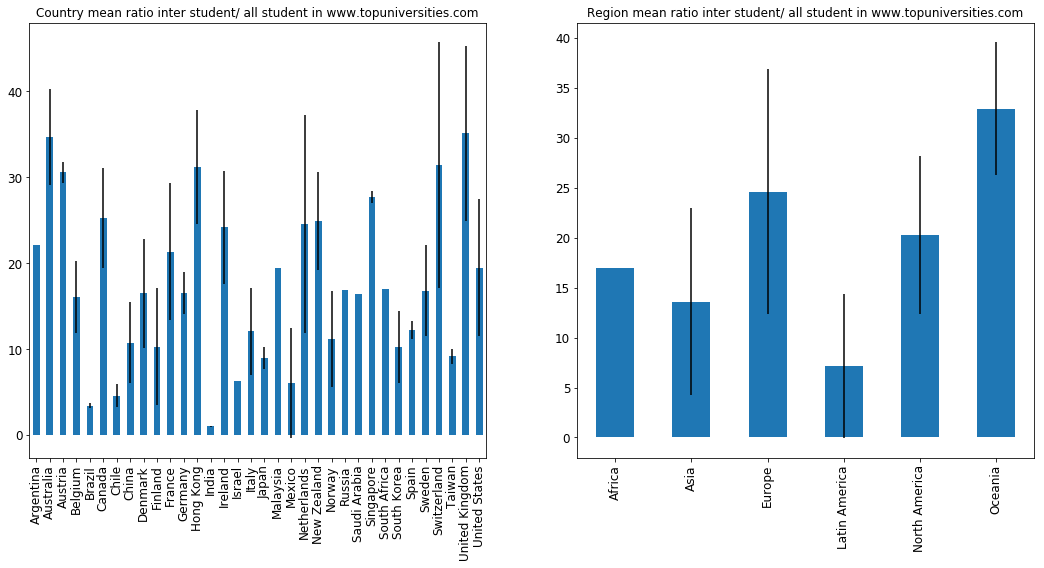

In [9]:
countrySTDMEAN = CountryStdMean('ratio inter student/ all student',All_country_1)
plt.subplot(1, 2, 1)
countrySTDMEAN['Mean'].plot.bar(yerr=countrySTDMEAN['Std'], figsize=(8,8), fontsize = 12, title='Country mean ratio inter student/ all student in www.topuniversities.com')

RegionSTDMEAN = regionStdMean('ratio inter student/ all student', All_country_1)
plt.subplot(1, 2, 2)
RegionSTDMEAN['Mean'].plot.bar(yerr=RegionSTDMEAN['Std'],figsize=(18,8), fontsize = 12, title='Region mean ratio inter student/ all student in www.topuniversities.com')
plt.show()

## Histogram Ratio Student/ Staff Analysis

The Country ratio histogram varies a lot within countries, there are countries as India, Brazil, Chile that almost don't have international students, whereas Switzerland, United Kingdom, Australia, Austria have a huge percentage of international students in their universities.

The region ratio histogram shows us that there are huge differences between different regions in the world. Indeed,  Latin America has a ratio 6 times lower than Oceania. We see that Europe and North America have values that are in the mean of all the regions. As stated before their high std is not only due to the large number of universities present in the top 200 but also related to the fact that they are composed of several countries for the Europe and several states with their own laws in the North America countries. 


## Ranking according by number of university in top 200

United States     47
United Kingdom    28
Germany           11
Netherlands       10
Japan              9
Australia          9
Canada             7
Switzerland        7
China              7
South Korea        7
France             5
Sweden             5
Hong Kong          5
Belgium            4
Italy              4
India              3
Spain              3
Denmark            3
Austria            2
Chile              2
Ireland            2
Norway             2
Finland            2
Taiwan             2
New Zealand        2
Brazil             2
Mexico             2
Singapore          2
Russia             1
Argentina          1
South Africa       1
Israel             1
Malaysia           1
Saudi Arabia       1
Name: country, dtype: int64

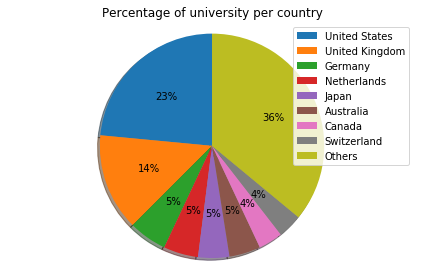

In [10]:
display(All_country_1['country'].value_counts())
labels = np.append(All_country_1['country'].value_counts().index[:8].values,'Others')
patch,text,autotexts = plt.pie(np.append(All_country_1['country'].value_counts()[:8].values,np.sum(All_country_1['country'].value_counts()[8:])), autopct='%1.f%%',shadow=True, startangle=90)
plt.legend(patch, labels, loc="best")
plt.axis('equal')
plt.title('Percentage of university per country')
plt.tight_layout()
plt.show()

Europe           89
North America    54
Asia             38
Oceania          11
Latin America     7
Africa            1
Name: region, dtype: int64

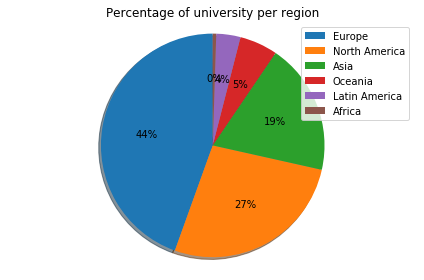

In [11]:
display(All_country_1['region'].value_counts())
labels = All_country_1['region'].value_counts().index
patch,text,autotexts = plt.pie(All_country_1['region'].value_counts(), autopct='%1.f%%',shadow=True, startangle=90)
plt.legend(patch, labels, loc="best")
plt.title('Percentage of university per region')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 200 top-ranking universities in www.timeshighereducation.com

In [12]:
#url of the json file 
URL='https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL)
page_body = r.text

dic_data = json.loads(page_body)

In [13]:
All_country=[]
for i in range(200):
    country_info={}
    relevant_info=['name','location','rank']
    for info in relevant_info:
        country_info[info]=dic_data['data'][i][info]
    url='https://www.timeshighereducation.com/'+dic_data['data'][i]['url']
    r = requests.get(url)
    page_body = r.text
    soup=BeautifulSoup(page_body, 'html.parser')

    stat= soup.find('div', class_='panel-pane pane-data-stats')
    data_given={}
    for a in stat.find_all('div',class_='value'):
        country_info[a.next_sibling.text]=a.text
    All_country.append(country_info)
All_country_2=pd.DataFrame(data=All_country)
All_country_2 =All_country_2.apply(lambda x: x.str.replace(',',''))
All_country_2=All_country_2.apply(lambda x: x.str.replace('=',''))
All_country_2=All_country_2.apply(lambda x: x.str.replace('%',''))
All_country_2=All_country_2.apply(pd.to_numeric, errors='ignore')
All_country_2 = All_country_2.rename(columns=lambda x: x.replace('location', 'country'))
All_country_2 = All_country_2.rename(columns=lambda x: x.replace('name', 'title'))
cols=list(All_country_2)
cols.pop(cols.index('Out-of-state Tuition and Fees'))
cols.pop(cols.index('On-campus Room and Board'))
cols.pop(cols.index('Salary after 10 years'))
cols.insert(0, cols.pop(cols.index('title')))
All_country_2= All_country_2.loc[:, cols]
All_country_3 = All_country_2

display(All_country_2.head())

,title,No. of students per staff,Number of Students,Percentage of International Students,Student Ratio of Females to Males,country,rank
0,University of Oxford,11.2,20409,38,46 : 54,United Kingdom,1
1,University of Cambridge,10.9,18389,35,45 : 55,United Kingdom,2
2,California Institute of Technology,6.5,2209,27,31 : 69,United States,3
3,Stanford University,7.5,15845,22,42 : 58,United States,3
4,Massachusetts Institute of Technology,8.7,11177,34,37 : 63,United States,5


In [14]:
#Mapping with the region of dataframe 1
country_region={}
country_region['Luxembourg'] = 'Europe'
country_region['Russian Federation'] = 'Europe'

for country in All_country_1['country'].unique():
    spec_country=All_country_1.loc[All_country_1['country'] == country]
    region=spec_country['region'].unique()
    country_region[country]=region[0]

All_country_2['region']=[country_region[x] for x in All_country_2['country']]

we can now repeat the analysis as we did before.
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

## Aggregating the data by  country and region.

The following function helped us to rank the universities according to the column of wish and according to Countries or Regions. Furthermore we also define two functions, CountryStdMean and RegionStdMean which each one creates a DataFrame with the mean and std values of the universities of eachy country or region.

In [15]:
classement_ratio1=All_country_2.sort_values('No. of students per staff',ascending=False)
display(classement_ratio1)
classement_ratio2=All_country_2.sort_values('Percentage of International Students',ascending=False)
#display(classement_ratio2)

,title,No. of students per staff,Number of Students,Percentage of International Students,Student Ratio of Females to Males,country,rank,region
99,University of Bonn,77.9,35619,13,55 : 45,Germany,100,Europe
124,University of Mannheim,74.5,10995,16,54 : 46,Germany,125,Europe
91,Technical University of Berlin,64.3,22390,20,34 : 66,Germany,92,Europe
163,University of Erlangen-Nuremberg,58.5,38730,12,49 : 51,Germany,162,Europe
78,RWTH Aachen University,57.7,43721,18,32 : 68,Germany,79,Europe
87,Free University of Berlin,57.0,34114,21,59 : 41,Germany,88,Europe
61,Humboldt University of Berlin,56.5,32172,17,NaN,Germany,62,Europe
40,Technical University of Munich,54.4,38689,23,34 : 66,Germany,41,Europe
144,University of Cologne,50.9,45087,10,65 : 35,Germany,145,Europe
174,Université Libre de Bruxelles,43.4,25343,35,55 : 45,Belgium,175,Europe


In [16]:
#display(All_country_2[151:200])
Region_ranking1 = country_ranking('No. of students per staff',All_country_2, True)
#Region_ranking2=region_ranking('Percentage of International Students',All_country_2, False)
#display(Region_ranking1.head(40))
display(Region_ranking1)


title  \
region        country                                                            
Oceania       New Zealand                               University of Auckland   
              Australia                         Australian National University   
              Australia                                   University of Sydney   
              Australia                        University of Western Australia   
              Australia                                University of Melbourne   
              Australia                          University of New South Wales   
              Australia                                      Monash University   
              Australia                                 University of Adelaide   
              Australia                               University of Queensland   
North America United States                              Vanderbilt University   
              United States                                    Yale University   
              United States                           Johns Hopkins University   
              United States                            University of Rochester   
              United States                                   Emory University   
              United States                                    Duke University   
              United States                           University of Pittsburgh   
              United States                                University of Miami   
              United States                                Columbia University   
              United States                              University of Chicago   
              United States                 California Institute of Technology   
              United States                         University of Pennsylvania   
              United States                                  Dartmouth College   
              United States                    Case Western Reserve University   
              United States                  Washington University in St Louis   
              United States                                Stanford University   
              United States                               Princeton University   
              United States                                  Boston University   
              United States                              Georgetown University   
              United States                             University of Michigan   
              United States              Massachusetts Institute of Technology   
...                                                                        ...   
Europe        Denmark                                 University of Copenhagen   
              Denmark                          Technical University of Denmark   
              Denmark                                        Aarhus University   
              Belgium                                         Ghent University   
              Belgium                                                KU Leuven   
              Belgium                         Université Catholique de Louvain   
              Belgium                            Université Libre de Bruxelles   
              Austria                                     University of Vienna   
Asia          Taiwan                                National Taiwan University   
              South Korea          Pohang University of Science and Technology   
              South Korea    Korea Advanced Institute of Science and Techno...   
              South Korea                            Seoul National University   
              South Korea                       Sungkyunkwan University (SKKU)   
              Singapore             Nanyang Technological University Singapore   
              Singapore                       National University of Singapore   
              Japan                                        University of Tokyo   
              Japan                                    

## Ploting the data 

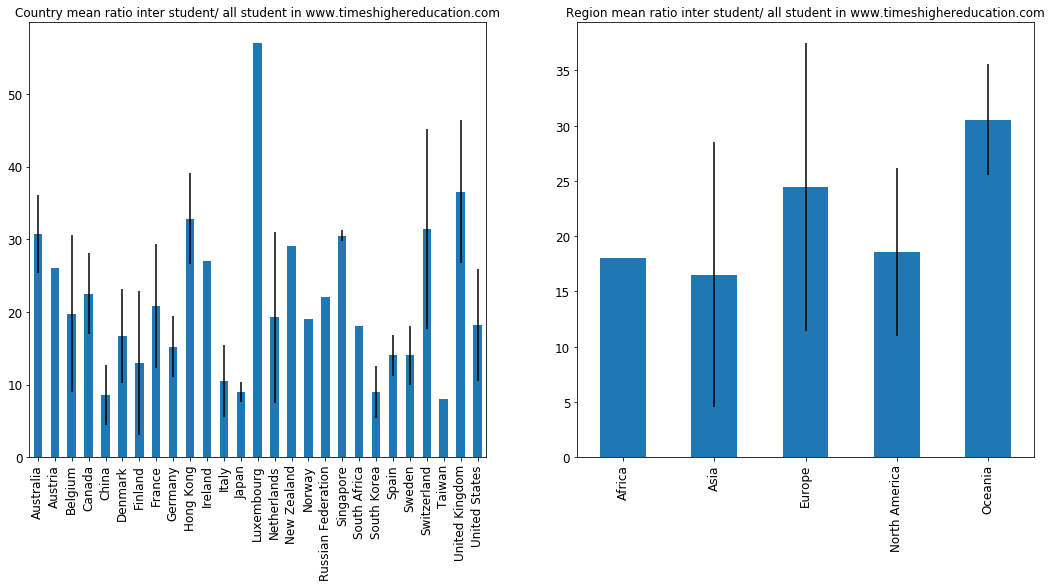

In [17]:
countrySTDMEAN = CountryStdMean('Percentage of International Students',All_country_2)
plt.subplot(1, 2, 1)
countrySTDMEAN['Mean'].plot.bar(yerr=countrySTDMEAN['Std'], figsize=(8,8), fontsize = 12, title = 'Country mean ratio inter student/ all student in www.timeshighereducation.com' )

RegionSTDMEAN = regionStdMean('Percentage of International Students', All_country_2)
plt.subplot(1, 2, 2)
RegionSTDMEAN['Mean'].plot.bar(yerr=RegionSTDMEAN['Std'],figsize=(18,8), fontsize = 12, title = 'Region mean ratio inter student/ all student in www.timeshighereducation.com')
plt.show()

## Histogram Ratio International Student/ All Students Analysis

This country mean ratio histogram brings us a new insight for the analysis of the university ranking, which is the outliers, indeed in www.timeshighereducation.com ranking Luxembourg belongs to the top 200. However, it's well-founded to ask if can we treat this country in the same way as other, knowing that it only contains a population about 500000 residents. 

For the region mean ration, the same analyse can be made, as there are no new insights

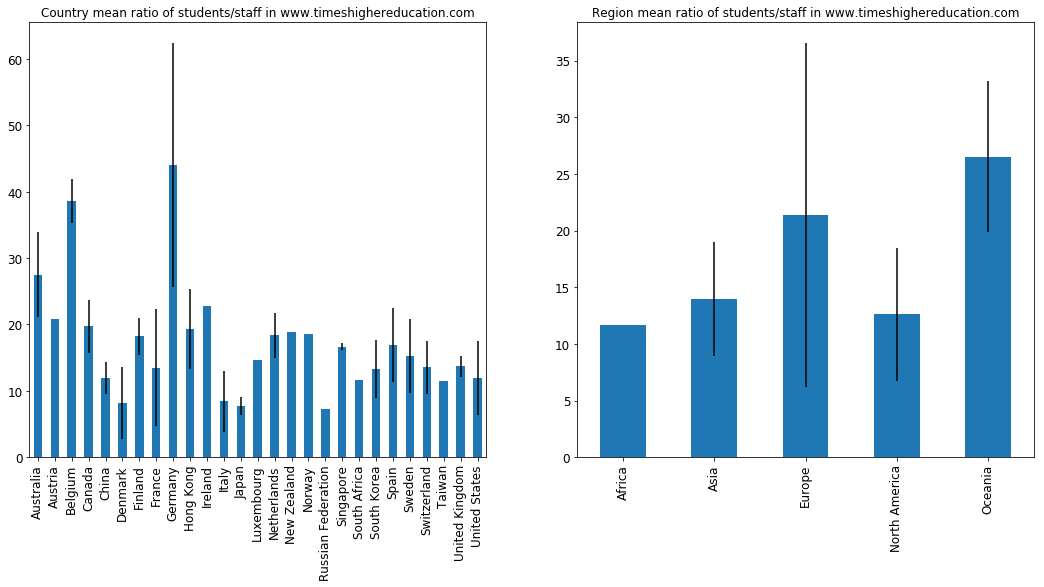

In [18]:
countrySTDMEAN = CountryStdMean('No. of students per staff',All_country_2)
plt.subplot(1, 2, 1)
countrySTDMEAN['Mean'].plot.bar(yerr=countrySTDMEAN['Std'], figsize=(8,8), fontsize = 12, title = 'Country mean ratio of students/staff in www.timeshighereducation.com' )
#Histogram Ratio Student/ Staff Analysis
RegionSTDMEAN = regionStdMean('No. of students per staff', All_country_2)
plt.subplot(1, 2, 2)
RegionSTDMEAN['Mean'].plot.bar(yerr=RegionSTDMEAN['Std'],figsize=(18,8), fontsize = 12, title = 'Region mean ratio of students/staff in www.timeshighereducation.com')
plt.show()

## Histogram Ratio Student/ Staff Analysis

The Country ratio histogram varies a lot within countries, but still there is a general tendency that evolves from 12 to 20 students per staff. In this webpage ranking there are less universities outliers that almost the same amount of student than staff as the previous ranking page.

This region ratio histogram varies much less than the previous ranking page, but we can still see that both have the same tendency i.e. Oceania has the largest average of student/staff and Europe has a large std.

## Ranking according to number of university in top 200

United States         62
United Kingdom        31
Germany               20
Netherlands           13
Australia              8
Switzerland            7
China                  7
Canada                 6
Sweden                 6
France                 6
Hong Kong              5
South Korea            4
Belgium                4
Denmark                3
Singapore              2
Spain                  2
Finland                2
Italy                  2
Japan                  2
Luxembourg             1
Norway                 1
South Africa           1
Taiwan                 1
New Zealand            1
Austria                1
Russian Federation     1
Ireland                1
Name: country, dtype: int64

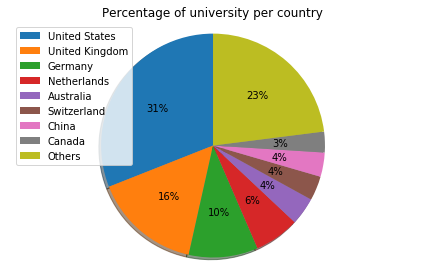

In [19]:
display(All_country_2['country'].value_counts())

labels = np.append(All_country_2['country'].value_counts().index[:8].values,'Others')
patch,text,autotexts = plt.pie(np.append(All_country_2['country'].value_counts()[:8].values,np.sum(All_country_2['country'].value_counts()[8:])), autopct='%1.f%%',shadow=True, startangle=90)
plt.legend(patch, labels, loc="best")
plt.axis('equal')
plt.title('Percentage of university per country')
plt.tight_layout()
plt.show()

Europe           101
North America     68
Asia              21
Oceania            9
Africa             1
Name: region, dtype: int64

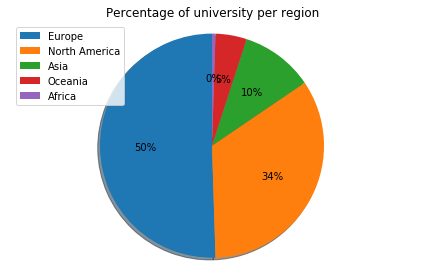

In [20]:
display(All_country_2['region'].value_counts())

labels = All_country_2['region'].value_counts().index
patch,text,autotexts = plt.pie(All_country_2['region'].value_counts(), autopct='%1.f%%',shadow=True, startangle=90)
plt.legend(patch, labels, loc="best")
plt.title('Percentage of university per region')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Interactive display (Need to run the code)

In [21]:
def f(Region,Dataset,Sorting_by):
    if (Dataset == True):
        if (Sorting_by == True):
            display(All_country_1.groupby('region').get_group(Region).sort_values('ratio student/ staff'))
        else :
            display(All_country_1.groupby('region').get_group(Region).sort_values('ratio inter student/ all student'))
    else :
        if (Sorting_by == True):
            display(All_country_2.groupby('region').get_group(Region).sort_values('No. of students per staff'))
        else :
            display(All_country_2.groupby('region').get_group(Region).sort_values('Percentage of International Students'))

# Function interact to implement interactive display
interact(f, Region =np.unique(All_country_1['region']), Dataset = {'Top Universities' : True, 'Time Higher Education' : False}, Sorting_by ={'Ratio student/staff' : True,'Ratio international/ all student' :False})

,title,country,number of international members,number of international students,number of members,number of students,rank_display,region,ratio inter student/ all student,ratio student/ staff
190,University of Cape Town,South Africa,379.0,3325.0,1733.0,19593.0,191,Africa,16.970347,11.305828


<function __main__.f>

## Merging the DataFrame

Match universities' names as well as you can, and explain your strategy

- To merge the two dataframes, we should modify the name and create a "merging" criteria since some universities' name were a bit different.

- First of all, we deleted all common word such as "for, a, of, ..." and split the university name in separated words. 

- Then, we created a "merging label" composed of the first 3 words of the university name. We decided to take the first 3 words to have a higher accuracy in the merging.

- Using the function pd.merge on the 2 dataset using the feature "merging" as a criteria for merging.

- Finally, after fixing some exceptions, we delete the universities which were not in both ranking.

In [22]:
stoplist = set('for a of the and to in - –'.split()) # List of common words

texts = [[word for word in title.lower().split() if word not in stoplist] # Split the name in separated words
        for title in All_country_1['title']]
All_country_1['merging'] = texts

texts2 = [[word for word in title.lower().split() if word not in stoplist]
        for title in All_country_2['title']]
All_country_2['merging'] = texts2

All_country_1['merging'] = All_country_1['merging'].apply(lambda x: ' '.join(map(str, x[:3]))) # Creating a new features with the first 3 words of the name
All_country_2['merging'] = All_country_2['merging'].apply(lambda x: ' '.join(map(str, x[:3]))) 

All_country_1['merging'] = All_country_1['merging'].replace('ucl (university college','university college london') # Replace manually for some execptions
All_country_2['merging'] = All_country_2['merging'].replace('école polytechnique fédérale','ecole polytechnique fédérale')

Rank = pd.merge(All_country_1, All_country_2,  how='outer', on=['merging']) # Merging using feature 'merging'

# This block of code is to add the value when the country of the title is missing
Rank['title_x'] = Rank['title_x'].replace(np.nan,0)
Rank['country_x'] = Rank['country_x'].replace(np.nan,0)
School_name = []
Country = []

for i,name in enumerate(Rank['title_x'].values) :
    if (name != 0) :
        School_name.append(name)
    else :
        School_name.append(Rank['title_y'].values[i])
Rank['School name'] = School_name

for i,name in enumerate(Rank['country_x'].values) :
    if (name != 0) :
        Country.append(name)
    else :
        Country.append(Rank['country_y'].values[i])
Rank['Country'] = Country

Rank.drop(['title_y','title_x','country_y','country_x'] ,axis=1,inplace=True)

Rank['rank_display'] = Rank['rank_display'].replace(np.nan,999)
Rank['rank'] = Rank['rank'].replace(np.nan,999)

# Cre
Rank_final = pd.DataFrame({'1 - School Name' : Rank['School name'],
                     '2 - Rank #1' : Rank['rank_display'],
                     '3 - Rank #2' : Rank['rank'],
                     '4 - Country' : Rank['Country'],
                     '5 - Region' : Rank['region_x'],
                     '6 - Percentage of international #1' : round(Rank['ratio inter student/ all student']), 
                     '7 - Percentage of international #2' : Rank['Percentage of International Students'],
                     '8 - Ratio Student /Staff #1' : Rank['ratio student/ staff'],
                     '9 - Ratio Student /Staff #2' : Rank['No. of students per staff'],
                     '10 - Number of students': Rank['Number of Students']})

Rank_final.drop(Rank_final.loc[Rank_final['2 - Rank #1'] == 999].index,inplace=True) # Drop the school when they are not in both rankings.
Rank_final.drop(Rank_final.loc[Rank_final['3 - Rank #2'] == 999].index,inplace=True)

display(Rank_final)



,1 - School Name,10 - Number of students,2 - Rank #1,3 - Rank #2,4 - Country,5 - Region,6 - Percentage of international #1,7 - Percentage of international #2,8 - Ratio Student /Staff #1,9 - Ratio Student /Staff #2
0,Massachusetts Institute of Technology (MIT),11177.0,1.0,5.0,United States,North America,34.0,34.0,3.711268,8.7
1,Stanford University,15845.0,2.0,3.0,United States,North America,23.0,22.0,3.705484,7.5
2,Harvard University,20326.0,3.0,6.0,United States,North America,23.0,26.0,5.156092,8.9
3,California Institute of Technology (Caltech),2209.0,4.0,3.0,United States,North America,29.0,27.0,2.366212,6.5
4,University of Cambridge,18389.0,5.0,2.0,United Kingdom,Europe,36.0,35.0,3.418944,10.9
5,University of Oxford,20409.0,6.0,1.0,United Kingdom,Europe,37.0,38.0,2.921481,11.2
6,UCL (University College London),30304.0,7.0,16.0,United Kingdom,Europe,48.0,49.0,4.898345,10.5
7,Imperial College London,15857.0,8.0,8.0,United Kingdom,Europe,54.0,55.0,4.094148,11.4
8,University of Chicago,13525.0,9.0,9.0,United States,North America,25.0,25.0,5.535729,6.2
9,ETH Zurich - Swiss Federal Institute of Techno...,19233.0,10.0,10.0,Switzerland,Europe,38.0,38.0,7.999596,14.6


Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

In [23]:
Rank.corr()

,number of international members,number of international students,number of members,number of students,rank_display,ratio inter student/ all student,ratio student/ staff,No. of students per staff,Number of Students,Percentage of International Students,rank
number of international members,1.000000,0.642269,0.591398,0.307286,-0.535601,0.426851,-0.305243,-0.012419,0.272815,0.323321,-0.358657
number of international students,0.642269,1.000000,0.469017,0.554713,-0.304190,0.536712,0.189868,0.307628,0.565648,0.420380,-0.261139
number of members,0.591398,0.469017,1.000000,0.762232,-0.311295,-0.077194,-0.271573,-0.106332,0.606367,-0.138735,-0.112859
number of students,0.307286,0.554713,0.762232,1.000000,-0.030620,-0.182748,0.329546,0.360594,0.981157,-0.288255,-0.003140
rank_display,-0.535601,-0.304190,-0.311295,-0.030620,1.000000,-0.362432,0.377351,0.296593,-0.101102,-0.187262,-0.166548
ratio inter student/ all student,0.426851,0.536712,-0.077194,-0.182748,-0.362432,1.000000,-0.111367,0.006459,-0.247326,0.955382,-0.329114
ratio student/ staff,-0.305243,0.189868,-0.271573,0.329546,0.377351,-0.111367,1.000000,0.564847,0.434916,-0.139061,0.179576
No. of students per staff,-0.012419,0.307628,-0.106332,0.360594,0.296593,0.006459,0.564847,1.000000,0.257120,-0.120413,0.107456
Number of Students,0.272815,0.565648,0.606367,0.981157,-0.101102,-0.247326,0.434916,0.257120,1.000000,-0.289970,-0.151891
Percentage of International Students,0.323321,0.420380,-0.138735,-0.288255,-0.187262,0.955382,-0.139061,-0.120413,-0.289970,1.000000,-0.214197


 The ranking one is based on the ratio of international student (less international leads to worst ranking)
 and on the ratio of student staff 1 (higher ratio worst ranking)  (which seems different from the second) 
 other very important features are not captured here (number of publications, proportion of job found right after, .. etc).
 
 And also we can notice that the Ratio Student staff between the two sites are not correlated which means that the values are different.
 
 

I propose to do a ranking composed of 30% of the first 30% of the second and 15% of the ranking percentage student and  25% on the ratio student/staff#1. We keep a strong relation to the two rankings because they have underlying informations that we do not have access to. We add a percentage of the student/staff which is important according to us and a another small pecentage of the (inverse because as the ratio is grwoing, the ranking too) international student.
It is indeed arbitrary but with no further information all ranking made will be arbitrary.

In [24]:
#all ratio used are normalized in order to be compared
#then we just sort the sum and create a ranking on that
Myranking=Rank_final.copy()
Myranking['2 - Rank #1']=Rank_final['2 - Rank #1']/sum(Rank_final['2 - Rank #1'])
Myranking['3 - Rank #2']=Rank_final['3 - Rank #2']/sum(Rank_final['3 - Rank #2'])
Myranking['6 - Percentage of international #1']=1/Rank_final['6 - Percentage of international #1']/np.nansum(1/Rank_final['6 - Percentage of international #1'])
Myranking['8 - Ratio Student /Staff #1']=Rank_final['8 - Ratio Student /Staff #1']/np.nansum(Rank_final['8 - Ratio Student /Staff #1'])

Myranking['My ranking']=0.3*Myranking['2 - Rank #1']+0.3*Myranking['3 - Rank #2']\
                        +0.25*Myranking['8 - Ratio Student /Staff #1']+0.2*Myranking['6 - Percentage of international #1']

Myranking=Myranking.sort_values('My ranking')
a=list(Myranking['My ranking'].values)
index = [a.index(v)+1 for v in a]
Myranking['FinalRanking']=index
MyfinalRank = pd.DataFrame({'0 - School Name' : Rank['School name'],
                     '1 - Rank Perso': Myranking['FinalRanking'],
                     '2 - Rank #1' : Rank['rank_display'],
                     '3 - Rank #2' : Rank['rank'],
                     '4 - Country' : Rank['Country'],
                     '5 - Region' : Rank['region_x'],
                     '6 - Percentage of international' : round(Rank['ratio inter student/ all student']), 
                     '7 - Ratio Student /Staff #1' : Rank['ratio student/ staff'],
                     '8 - Ratio Student /Staff #2' : Rank['No. of students per staff'],
                     '9 - Number of students': Rank['Number of Students']})

MyfinalRank=MyfinalRank.sort_values('1 - Rank Perso')
display(MyfinalRank.head())

,0 - School Name,1 - Rank Perso,2 - Rank #1,3 - Rank #2,4 - Country,5 - Region,6 - Percentage of international,7 - Ratio Student /Staff #1,8 - Ratio Student /Staff #2,9 - Number of students
5,University of Oxford,1.0,6.0,1.0,United Kingdom,Europe,37.0,2.921481,11.2,20409.0
3,California Institute of Technology (Caltech),2.0,4.0,3.0,United States,North America,29.0,2.366212,6.5,2209.0
4,University of Cambridge,3.0,5.0,2.0,United Kingdom,Europe,36.0,3.418944,10.9,18389.0
0,Massachusetts Institute of Technology (MIT),4.0,1.0,5.0,United States,North America,34.0,3.711268,8.7,11177.0
7,Imperial College London,5.0,8.0,8.0,United Kingdom,Europe,54.0,4.094148,11.4,15857.0


In [25]:
MyfinalRank.corr()

,1 - Rank Perso,2 - Rank #1,3 - Rank #2,6 - Percentage of international,7 - Ratio Student /Staff #1,8 - Ratio Student /Staff #2,9 - Number of students
1 - Rank Perso,1.000000,0.871803,0.821178,-0.473943,0.443173,0.218760,0.048867
2 - Rank #1,0.871803,1.000000,-0.166548,-0.364287,0.377351,0.296593,-0.101102
3 - Rank #2,0.821178,-0.166548,1.000000,-0.328941,0.179576,0.107456,-0.151891
6 - Percentage of international,-0.473943,-0.364287,-0.328941,1.000000,-0.112677,0.003380,-0.248485
7 - Ratio Student /Staff #1,0.443173,0.377351,0.179576,-0.112677,1.000000,0.564847,0.434916
8 - Ratio Student /Staff #2,0.218760,0.296593,0.107456,0.003380,0.564847,1.000000,0.257120
9 - Number of students,0.048867,-0.101102,-0.151891,-0.248485,0.434916,0.257120,1.000000
